In [1]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

___

Mike Wisniewski
___

# In Class Assignment Three
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (or HTML of the rendered notebook)  before the end of class (or right after class). The initial portion of this notebook is given before class and the remainder is given during class. Please answer the initial questions before class, to the best of your ability. Once class has started you may rework your answers as a team for the initial part of the assignment. 

<a id="top"></a>
## Contents
* <a href="#LoadingKDD">Loading KDDCup Data</a>
* <a href="#kdd_eval">KDDCup Evaluation and Cross Validation</a>
* <a href="#data_snooping">More Cross Validation</a>
* <a href="#stats">Statistical Comparison</a>

**Before coming to class**, please make sure you have the latest version of `scikit-learn`. This notebook was created for version 0.18 and higher. 

________________________________________________________________________________________________________

<a id="LoadingKDD"></a>
<a href="#top">Back to Top</a>
## Loading KDDCup Data

Please run the following code to read in the "KDD Cup" dataset from sklearn's data loading module. It consists of examples of different simulated attacks for the 1998 DARPA Intrusion Detection System (IDS). 

This will load the data into the variable `ds`. `ds` is a `bunch` object with fields like `ds.data` and `ds.target`. The field `ds.data` is a numpy matrix of the continuous features in the dataset. **The object is not a pandas dataframe. It is a numpy matrix.** Each row is a set of observed instances, each column is a different feature. It also has a field called `ds.target` that is an integer value we are trying to predict (i.e., a specific integer represents a specific person). Each entry in `ds.target` is a label for each row of the `ds.data` matrix. 

In [97]:
# fetch the dataset
from sklearn.datasets import  fetch_kddcup99
from sklearn import __version__ as sklearn_version

print('Sklearn Version:',sklearn_version)
ds =  fetch_kddcup99(subset='http')

Sklearn Version: 0.24.2


In [98]:
import numpy as np
# get some of the specifics of the dataset
X = ds.data
y = np.array(ds.target != b'normal.')
y = y.astype(int)

n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 58725
n_features: 3
n_classes: 2


___
**Question 1:** How many instances are in the binary classification problem loaded above? How many instances are in each class? **Plot a pie chart or bar chart of the number of instances in each of the classes.**

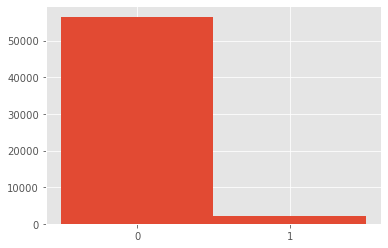

Number of instances in each class: [56516  2209]
Number of instances in class 0 (normal logins): 56516
Number of instances in class 1 (attacks): 2209


In [99]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#=== Fill in code below========
num_instances = np.bincount(y)
plt.hist(y, bins=np.arange(3)-0.5, align="mid")
plt.xticks(range(0,2))
plt.show()
print('Number of instances in each class:', num_instances)
print("Number of instances in class 0 (normal logins):", num_instances[0])
print("Number of instances in class 1 (attacks):", num_instances[1])

<a id="kdd_eval"></a>
<a href="#top">Back to Top</a>
## KDDCup Evaluation and Cross Validation

(0.9894891008174387, 1.0)

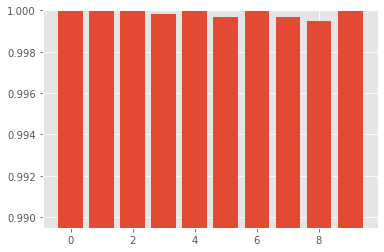

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression()
#select cross validation
cv = KFold(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(accuracy_score)
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

____
**Question 2** Is the code above a proper separation of training and testing sets for the given dataset (i.e., using KFold)? Why or why not? 

No.  A fold could have uneven amounts of classes.  Stratifying y would be an enhancement to this approach - or in theory.  I will use StratifiedKFold as StratifiedShuffleSplit may cause overlapping between the Train and Test sets per shuffle.
___

**Question 3:** Is the evaluation metric chosen in the above code appropriate for the dataset (i.e., using accuracy)? Why or Why not?

Maybe, but usually no.  Accuracy is one metric to gauge performance, but there could be an instance where inside a fold there was 99 class 0 and 1 class 1, in which the model could just predict class 0 all the time, thereby achieving a 99% accuracy.  Precision, recall, or F1 may be more suited.  In the context of this dataset, where a "Yes" prediction is an attack and a "No" prediction is not an attack, it is better to use recall or F1 to gauge performance.  We use either metric because we care about lowering False Negatives (i.e. we predicted a login was normal when it was actually malicious).  We don't want to accidentally let a malicious actor to break into a system.  On the flip-side, if a False Positive were to occur, so long as the rate of False Positives is low enough to not hamper employee efficiency, then the model should be effective at keeping False Negatives near 0 while keeping False Positives low.  For this case, we will use recall to achieve this
___

**Exercise 1:** If the code above is not a proper separation of the train or does not use the proper evaluation criteria, fix the code in the block below to use appropriate train/test separation and appropriate evaluation criterion (criteria). **Mark changes in the code with comments.**

Average Recall: 0.9972850678733032


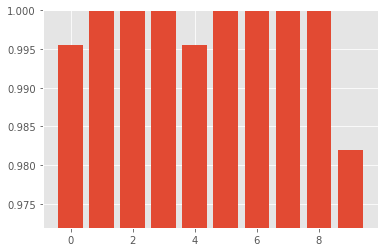

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
# these imports above might help you

#=====Write your code below here=================
# select model
clf = LogisticRegression()

#select cross validation
cv = StratifiedKFold(n_splits=10)  # using a stratified K fold approach

# select evaluation criteria
my_scorer = make_scorer(recall_score)  # using recall as the scoring criteria

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
print("Average Recall:", np.mean(per_fold_eval_criteria))

____
**Question 4**: Does the learning algorithm perform well based on the evaluation criteria? Why or why not?

It performs well based on statistics alone.  I don't think it performs well based on DARPA's criteria.  This approach stratifies the classes, so we have a roughly even amount of classes per fold.  This approach uses F1 scoring to take into consideration false negatives (of which we want to eliminate) while keeping low False Positives.  This achieves the criteria of keeping False Positives low.  However, let's view our average recall score of 0.997.  This means that 0.003, we miss -> 0.003 x 2,209 =~ 6.6 attacks missed.  For DARPA, this should be 0.  6 attacks could bring down a system.

Viewing F1 (which I did out of curiousity), we had an F1_score on average of 0.998, which tells us that 0.002 x 2,209 = 4.4 attacks missed.  This is still too high for DARPA.
___


<a id="data_snooping"></a>
<a href="#top">Back to Top</a>

## More Cross Validation

**Exercise 2:** Does the code below contain any errors in the implementation of the cross validation? If so, fix the code below so that there are no longer any errors in the cross validation.


*Explain any cross validation errors here (double click to edit)*

(0.9719004524886877, 1.0)

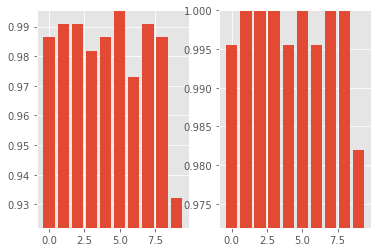

In [102]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


#======If there are errors, fix them below======
n_components = 1
pca = PCA(n_components=n_components)
Xpca = pca.fit_transform(X)

clf = Pipeline([('scl',StandardScaler()),
                ('clf',LogisticRegression())])

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=Xpca,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.subplot(1,2,1)
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])


# =====fixed code======
# write the fixed code (if needed) below

# PCA needs to be within the Pipeline
# number of components is 1?  Let's make that 2
n_components = 2

clf = Pipeline([('scl',StandardScaler()),
                ('pca',PCA(n_components=n_components)),
                ('clf',LogisticRegression())])

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.subplot(1,2,2)
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

___

# Circumstances Change
For this question, the circumstances for the DARPA KDD99 cup are changed in the following way:
- When the model for detecting attacks is deployed, we now think that it will often need to be retrained because new attacks will emerge.
 - DARPA anticipates that there will be a handful of different style attacks on their systems that have never been seen before. To detect these new attacks, they are employing programmers and analysts to find them manually every day. 
 - DARPA believes the perpetrators of these new attacks are more sophisticated, so finding the new attacks will take priority over detecting the older, known attacks. 
- DARPA wants to use your learning algorithm for detecting only these new attacks. However, they tell you that the amount of training data for the new attacks will be extremely small. That is, the analysts can only identify a handful of new style attacks each day (so you will only have about 3-5 examples of the attacks for training).
- **DARPA asks you: Do you think its a good idea to employ retraining your model each day to find these new attacks?** They need an answer in the next 20 minutes.  

**Question 5**: How would you change the method of cross validation to answer this question from DARPA? That is, how can you change your cross validation method to better mirror how your system will be used and deployed by DARPA when there are only 3-5 attack examples available for training? *Note: you do not have access to these new training examples. You need to change you cross validation method with the existing data to answer this question.* 

I think a method of approach would be to have between 3 and 5 attacks per fold.  So, in stratification, we would set an upper and lower limit on stratification to train the model upon.  This means we would need to increase the number of folds in order to decrease the size of testing (and therefore stratified y) per fold.  Effectively, we would have 2,209 / 5 folds or 442 folds.
___

In [103]:
#plotting function for use in next question
# takes input 'test_scores', axis labels, and an x-axis label
def plot_filled(test_scores,train_x_axis, xlabel=''):
    
    test_mean = np.percentile(test_scores,50, axis=1)
    test_max = np.percentile(test_scores,95, axis=1) 
    test_min = np.percentile(test_scores,5, axis=1) 

    plt.plot(train_x_axis, test_mean,
             color='blue', linestyle='--',
             marker='s', markersize=5,
             label='validation set')

    plt.fill_between(train_x_axis,
                     test_min,
                     test_max,
                     alpha=0.15, color='blue')

    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Evaluation Criterion')
    plt.legend(loc='lower right')
    plt.tight_layout()

___
DARPA is also concerned about how much training data they will need from the analysts in order to have a high performing model. They would like to use the current dataset to help answer that question. The code below is written for you to help answer DARPA's question about how many examples will be needed for training. Examine the code and the output (please rerun with your evaluation criteria), then answer the following question:

**Question 6**: Based on the analysis graphed below, how many positive examples are required to have a good tradeoff between bias and variance for the given evaluation criteria? Why? *Note: the x-axis really is a percentage, so the value 0.1 is actually 0.1%.*

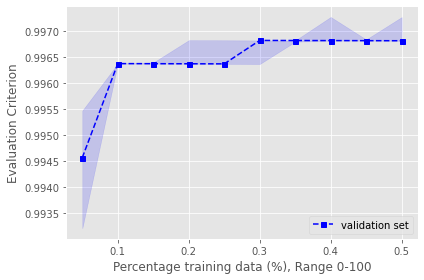

In [104]:
clf = LogisticRegression()

test_scores = []
train_sizes=np.linspace(5e-4,5e-3,10)

for size in train_sizes:
    cv = StratifiedShuffleSplit(n_splits=100,
                                train_size = size,
                                test_size = 1-size,
                               )
    test_scores.append(cross_val_score(estimator=clf,X=X,y=y,cv=cv,scoring=my_scorer))

plot_filled(np.array(test_scores), train_sizes*100, 'Percentage training data (%), Range 0-100')

___
It appears that there is good performance at around 0.1% of training data as the trade-off appears to level off after.  Additionally, the validation is in-line with model accuracy, meaning there is little variance.  As we add more training data, the model starts to vary until around 0.35% of training data, from which it has a better fit.  The model only needs to see above 0.1% of the data as the difference in the evaluation criteria between 0.1% and 0.35% is small (roughly 0.5% difference).
___

___
<a id="stats"></a>
<a href="#top">Back to Top</a>

# Statistical Comparison
Now lets create a few different models and see if any of them have statistically better performances. 

We are creating three different classifiers below to compare to one another. For creating different training and testing splits, we are using stratified shuffle splits on the datasets. 



In [105]:
clf1 = LogisticRegression(C=100)
clf2 = LogisticRegression(C=1)
clf3 = LogisticRegression(C=0.1)

train_size = 0.003 # small training size
cv = StratifiedShuffleSplit(n_splits=10,train_size=train_size,test_size=1-train_size)

evals1 = cross_val_score(estimator=clf1,X=X,y=y,scoring=my_scorer,cv=cv)
evals2 = cross_val_score(estimator=clf2,X=X,y=y,scoring=my_scorer,cv=cv)
evals3 = cross_val_score(estimator=clf3,X=X,y=y,scoring=my_scorer,cv=cv)

**Question 7**: Given the code above, what statistical test is more appropriate for selecting confidence intervals, and **why**? Your options are:
- **A**: approximating the evaluation criterion as a binomial distribution and bounding by the variance (the first option we used in the flipped lecture video)
- **B**: approximating the bounds using the folds of the cross validation to get mean and variance (the second option we used in the flipped lecture video)
- **C**: Either are acceptable statistical tests for obtaining confidence intervals

I think B is the most appropriate response because the cross validation takes into consideration separate training and testing sets.  Keeping these data separate is important for aforementioned reasons (imbalanced classes for example).  Thus, when calculating the mean and variance from this approach, we arrive at a much truer mean and variance as opposed to option A.  Option A, although good, genearlizes the distribution of the evaluation criteria a little more than what might be intended for this exercise.  Binomial distributions also assume a same probability of output per instance - but this case does not follow this rule.
___

___
**Final Exercise:** With 95% confidence, perform the statistical test that you selected above. Is any model or set of models statistically the best performer(s)? Or can we not say if the models are different with greater than 95% confidence?

If you chose option A, use a multiplier of Z=1.96. The number of instances used in testing can be calculated from the variable `train_size`.

If you chose option B, use a multiplier of t=2.26 and k=10.

In [128]:
#===================================================
# Enter your code below

t = 2.26 / np.sqrt(10)  # 2.26 is looked up in a book for 95% CI

def evaluation(acc1, acc2):
    e = (1-acc1) - (1-acc2)
    stdtot = np.std(e)
    dbar = np.mean(e)
    return dbar - t * stdtot, dbar + t * stdtot

eval1_2 = evaluation(evals1, evals2)
eval1_3 = evaluation(evals1, evals3)
eval2_3 = evaluation(evals2, evals3)

print("The range between clf1 and clf2:", eval1_2, "which does not include 0, therefore with 95% confidence, we can deduce that clf1 and clf2 are different from each other")
print()
print("The range between clf1 and clf3:", eval1_3, "which does not include 0, therefore with 95% confidence, we can deduce that clf1 and clf3 are different from each other")
print()
print("The range between clf2 and clf3:", eval2_3, "which does not include 0, therefore with 95% confidence, we can deduce that clf2 and clf3 are different from each other")
print()
print("Model 1 has statistically the best accuracy:", np.mean(evals1), "with 95% confidence")
#===================================================

The range between clf1 and clf2: (-0.0004541326067211138, -0.0004541326067211138) which does not include 0, therefore with 95% confidence, we can deduce that clf1 and clf2 are different from each other

The range between clf1 and clf3: (-0.004646831834205261, -0.003981687693496744) which does not include 0, therefore with 95% confidence, we can deduce that clf1 and clf3 are different from each other

The range between clf2 and clf3: (-0.004192699227484148, -0.0035275550867756304) which does not include 0, therefore with 95% confidence, we can deduce that clf2 and clf3 are different from each other

Model 1 has statistically the best accuracy: 0.997275204359673 with 95% confidence


    ________________________________________________________________________________________________________

That's all! Please **save (make sure you saved!!!) and upload your rendered notebook** and please include **team member names** in the notebook submission.